## FineTuning Gemma3n for Medical VQA on ROCOv2

We will finetune the latest **gemma 3n** of latest **Gemma 3** lineup of ***Google's Gemmaverse***. We will finetune both **Vision** and **Language** components. We will use `UnSloth`, `HuggingFace`, `TRL` and so on.

### Installation

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [2]:
%%capture
# Install latest transformers for Gemma 3N
!pip install --no-deps transformers==4.53.1 # Only for Gemma 3N
!pip install --no-deps --upgrade timm # Only for Gemma 3N

### Unsloth

In [3]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, processor = FastVisionModel.from_pretrained(
    "unsloth/gemma-3n-E2B-it",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.7.3: Fast Gemma3N patching. Transformers: 4.53.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3N does not support SDPA - switching to eager!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/2.65G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/469M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

We now add LoRA adapters for parameter efficient fine-tuning, allowing us to train only 1% of all model parameters efficiently.

We will fine-tune the vision component and the language component both for gemma3n. Additionally, you can choose to fine-tune the attention modules, the MLP layers, or both!

In [4]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,                           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,                  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,               # We support rank stabilized LoRA
    loftq_config = None,               # And LoftQ
    target_modules = "all-linear",    # Optional now! Can specify a list if needed
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

Unsloth: Making `model.base_model.model.model.language_model` require gradients


<a name="Data"></a>
### Data Prep
We'll be using a sampled version of the ROCO radiography dataset. You can access the dataset [here](https://huggingface.co/datasets/unsloth/Radiology_mini). The full dataset is [here](https://huggingface.co/datasets/eltorio/ROCOv2-radiology).

The dataset includes X-rays, CT scans and ultrasounds showcasing medical conditions and diseases. Each image has a caption written by experts describing it. The goal is to finetune a VLM to make it a useful analysis tool for medical professionals.

In [5]:
from datasets import load_dataset

dataset = load_dataset("unsloth/Radiology_mini", split="train")

README.md:   0%|          | 0.00/610 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/79.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1978 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/327 [00:00<?, ? examples/s]

Let's take an overview of the dataset. We'll examine the a image and its corresponding caption.

In [6]:
dataset

Dataset({
    features: ['image', 'image_id', 'caption', 'cui'],
    num_rows: 1978
})

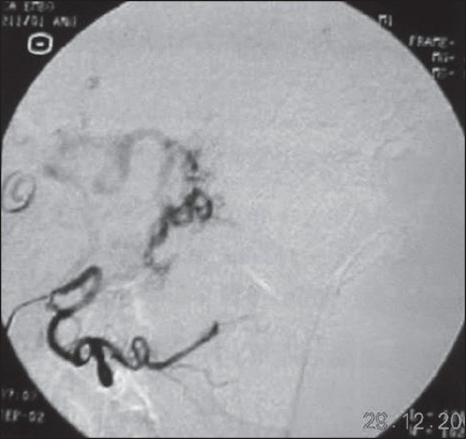

In [21]:
dataset[20]["image"]

In [22]:
dataset[20]["caption"]

'Post embolisation angiogram using PVA particles showed a marked reduction in vascularity'

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": instruction}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": answer} ]
},
]
```

We will craft an custom instruction asking the VLM to be an expert radiologist.

A Radiologist is a medical doctor specializing in interpreting medical images to diagnose and treat diseases. They use various imaging techniques like X-rays, CT scans, MRI, and ultrasound to visualize the inside of the body. Radiologists play a crucial role in guiding treatment decisions and monitoring patient progress.

In [9]:
instruction = "You are an expert radiologist. Describe accurately what you see in this image."

def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["caption"]}]},
    ]
    return {"messages": conversation}
pass

Let's convert the dataset into the "correct" format for finetuning:

In [10]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

The first example is now structured like below:

In [11]:
converted_dataset[20]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert radiologist. Describe accurately what you see in this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=466x439>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Post embolisation angiogram using PVA particles showed a marked reduction in vascularity'}]}]}

Before fine-tuning, let us evaluate the base model's performance. We do not expect strong results, as it has not encountered this chat template before.

In [12]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[20]["image"]
instruction = "You are an expert radiologist. Describe accurately what you see in this image."

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

# Convert grayscale image to RGB
if image.mode == 'L':
    image = image.convert('RGB')


inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

## Radiologic Findings:

This grayscale angiogram demonstrates a **posterior cerebral artery (PCA) territory infarct**. 

**Key findings:**

* **Infarct:** A focal region of non-perfused tissue is evident within the PCA territory, characterized by a characteristic "death shroud" appearance. This indicates a vascular occlusion.
* **Branching:** The PCA displays multiple branching patterns, typical of the artery's anatomy. 
* **Normal vessel lumen:** The remaining portions of the PCA vessels appear normal in caliber and lumen. 
* **No evidence of hemorrhage:** There is no indication of bleeding or acute ischemic stroke in the image. 

**Interpretation:**

The image shows a confirmed ischemic stroke within the posterior cerebral artery territory. This is consistent with the clinical presentation of a posterior cerebral artery occlusion. 

**Disclaimer:** This interpretation is based solely on the provided image and should be considered in conjunction with clinical findings and patient his

You can see it's absolutely terrible! It doesn't follow instructions at all

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [13]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model=model,
    train_dataset=converted_dataset,
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(model, processor, resize=512),
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        gradient_checkpointing = False,

        # use reentrant checkpointing
        # gradient_checkpointing_kwargs = {"use_reentrant": False},
        max_grad_norm = 0.3,              # max gradient norm based on QLoRA paper
        warmup_steps = 5,                 # Use when using max_steps
        max_steps = 60,
        # warmup_ratio = 0.03,
        # num_train_epochs = 2,           # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        save_strategy="steps",
        optim = "adamw_torch_fused",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",             # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_seq_length = 2048,
    )
)

In [14]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
10.988 GB of memory reserved.


In [15]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,978 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 21,135,360 of 5,460,573,632 (0.39% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
1,11.555500
2,10.761400
3,10.443900
4,12.511600
5,10.192500
6,10.138500
7,12.108200
8,10.742000
9,11.045700
10,10.775600


In [16]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

520.4965 seconds used for training.
8.67 minutes used for training.
Peak reserved memory = 10.988 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 74.54 %.
Peak reserved memory for training % of max memory = 0.0 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can modify the instruction and input—just leave the output blank.

We'll use the best hyperparameters for inference on Gemma3n: `top_p=0.95`, `top_k=64`, and `temperature=1.0`.

In [18]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[20]["image"]
instruction = "You are an expert radiologist. Describe accurately what you see in this image."

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

# Convert grayscale image to RGB
if image.mode == 'L':
    image = image.convert('RGB')


inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

The image shows a vascular angiogram of the brain with multiple small, irregular vessels.<end_of_turn>


Now you can see it's start following our instructions, giving the accurate answers.

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, use Hugging Face’s `push_to_hub` for online saving, or `save_pretrained` for local storage.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [23]:
model.save_pretrained("lora_model")  # Local saving
processor.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# processor.push_to_hub("your_name/lora_model", token = "...") # Online saving

['lora_model/processor_config.json']

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [32]:
if False:
    from unsloth import FastVisionModel

    model, processor = FastVisionModel.from_pretrained(
        model_name="lora_model",  # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit=True,  # Set to False for 16bit LoRA
        # attn_implementation="eager",
    )
    FastVisionModel.for_inference(model)  # Enable for inference!

FastVisionModel.for_inference(model)  # Enable for inference!

sample = dataset[20]
image = sample["image"].convert("RGB")
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": sample["caption"],
            },
            {
                "type": "image",
            },
        ],
    },
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor.tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

The image shows a post embolisation angiogram using PVA particles showed a marked reduction in vascularity.<end_of_turn>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", processor,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", processor, token = "PUT_HERE")

Play with the Notebook, See you in the next one! Bye 😀